In [91]:
%%file SGD.py
#Import library

from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix, vstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpi4py import MPI
import pandas as pd
import numpy as np
import time
import scipy
import os
import re

#Initialize communicators
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

#Pre-processing virus data
def virus():
    path = "/home/kritz/Downloads/dataset/"
    label = []
    data = np.array([])
    #Listing all the files in directory
    for rootdir, subdirs, files in os.walk(path):
        if files:
            for file in sorted(files):
                #Reading the data into sparse matrix from libsvm
                x,y = load_svmlight_file(rootdir+'/'+file)
                #Adding empty rows to compensate for missing columns in these four files
                if file in ["2011-09.txt","2013-07.txt","2013-09.txt","2014-01.txt"]:
                    update = np.zeros((x.shape[0],1))
                    x = scipy.sparse.hstack((x,np.array((update))))
                label.extend(y)
                #Adding all files to same csr matrix
                data = scipy.sparse.vstack((data,x))
    print(len(y),data.shape)
    data = data.tocsr()
    return(data[1:,].tocsr(),label)

#Pre-processing Kdd data
def Kdd():
    path = "/home/kritz/Downloads/cup98LRN.txt"
    df = pd.read_csv(path,low_memory=False)

    df = df.iloc[1:10000,:]
    #Getting the numerical and categorical columns
    cols = df.columns
    numCol = df._get_numeric_data().columns
    catCol = list(set(cols) - set(numCol))
    #Type casting for float and string
    for each in numCol:
        df[each] = df[each].astype('float')
    for each in catCol:
         df[each] = df[each].astype('category')
            
    #Filling mean values to Nans 
    newDf = pd.get_dummies(df,drop_first = True)  
    newDf = newDf.fillna(newDf.mean())

    #Reducing the dimension of predictor space based on variable importance
    X, y = newDf.loc[:,newDf.columns != 'TARGET_D'], newDf.loc[:,df.columns == 'TARGET_D']
    XNew = SelectKBest(chi2, k=200).fit_transform(X, y)

    return(scipy.sparse.csr_matrix(XNew),y)

#Sending the data from root process to others
def dataDistribute(data):
    '''All the send functions in root process'''
    rows = data.shape[0]
    for i in range(1,size):
        startIndex = int((i-1)*(rows/(size-1)))
        endIndex = int(((rows/(size-1))*i))
        ##print("Index",startIndex,endIndex)
        #May cause index out of range due to index strting from 0, but we are counting from 1
        if endIndex > rows:
            endIndex = int(rows)
        comm.send(data[startIndex:endIndex,:],dest = i,tag =1)

#Splitting data into train and test        
def trainTestSplit(data,y):
    #3. Split the data into test and train
    #Add bias
    print("Data raw ", data.shape)
    bias = np.ones((data.shape[0],1))
    dataBias = scipy.sparse.hstack([data,np.array(bias)])
    dataBias = dataBias.tocsr()
    print("After bias ",dataBias.shape,len(y))
    #Adding target
    y = np.reshape(y,(len(y),1))
    dataXY = scipy.sparse.hstack((dataBias,y)).tocsr()
    print("After y ",dataXY.shape)
    #Generate a random list of true and false and assign train and test based on those values
    split = np.random.rand(dataXY.shape[0]) < 0.7
    #Assign train to true
    train= dataXY[split]
    #Assign test to false
    test = dataXY[~split]
    return(train,test)

#Loss function
def leastSquareLoss(train,beta):
    yPredicted = train[:,:-1].dot(beta)
    leastSquareLoss = (np.square(train[:,-1]-yPredicted)).sum()
    return(leastSquareLoss)

#Function for derivative
def derivative(train,beta):
    x,y = train[:,:-1],train[:,-1]
    predicted = y - (x.dot(beta))
    #print((-2 * x.T.dot(predicted)).shape)
    return (-2 * x.T.dot(predicted))

#Stochastic gradient calculation
def SGD(train,beta,alpha):
    #Shuffling csr
    index = np.arange(np.shape(train)[0])
    np.random.shuffle(index)
    train = train[index,:]
    #Looping through each row in part file
    for each in train:
        #Computing next beta
        betaNext = beta - (alpha*derivative(each,beta))
        beta = betaNext  
    return(beta)

betaPart,updatedBeta,flag = None,None,False
iteration,trainRmse,testRmse,trainloss,testloss,times = 0,[],[],[],[],[]

#Main program,this part is used to send the heavy data to workers only once, later betas are passed
if rank == 0:
    updatedBeta,betaPart =  None,None
    data,y = virus() 
    train,test = trainTestSplit(data[:6000,:],y[:6000])
    beta = np.zeros(((train.shape[1])-1,1))
    print("Shape of train at root ",train.shape)
    dataDistribute(train)

else:
    partFile = comm.recv(source = 0,tag=1)
    beta = None
    test = None
    print("At rank ",rank, " size of data received is ",partFile.shape)

comm.Barrier()  
    
#Epochs
while flag == False :  
    tic = time.time()
    #Ensuring all workers have updated betas
    beta = comm.bcast(beta,root = 0) 
    test = comm.bcast(test,root = 0) 

    comm.Barrier()
    
    #Workers compute local beta updates
    if rank != 0:   
        betaPart = SGD(partFile,beta,0.00000000001)

    comm.Barrier() 
    #Sending to worker for global update
    updatedBeta = comm.gather(betaPart,0)
    comm.Barrier()

    if rank == 0:
        #Calculating loss and appending results
        lossOld = leastSquareLoss(train,beta)
        updatedBeta = np.sum(np.array(updatedBeta)[1:,])/(size-1)
        lossNew = leastSquareLoss(train,updatedBeta)
        if lossOld - lossNew <= 0.000000000000000001:
            print("Algorithm converged")
            flag = True
        if iteration > 100:
            print("Algorithm did not converge in 100 iterations")
            flag = True
        iteration = iteration+1
        temp = leastSquareLoss(test,beta)
        testRmse.append(np.sqrt(temp/test.shape[0]))
        trainRmse.append(np.sqrt(lossOld/train.shape[0]))
        trainloss.append(lossOld)
        testloss.append(temp)
        times.append(time.time()-tic)
        beta = updatedBeta
    
    #Updating all workers with new betas
    comm.Barrier()
    root = comm.bcast(flag,root = 0)
    comm.Barrier()
    print("Iteration ",iteration)
    
    #Writing results to a csv file
    if flag==True:
        loss = pd.DataFrame({'trainloss': trainloss,'testloss': testloss,'trainRmse':trainRmse,'testRmse': testRmse,'time':times})
        loss.to_csv('ResidualsVirus1.csv', sep='\t',index = False)
        #Forcefully exiting since break did not kill all the processes
        comm.Abort()

Overwriting SGD.py


In [93]:
!mpiexec -n 2 python SGD.py

^C
Ctrl-C caught... cleaning up processes


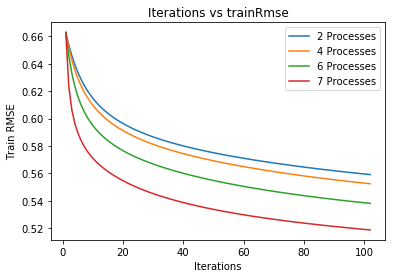

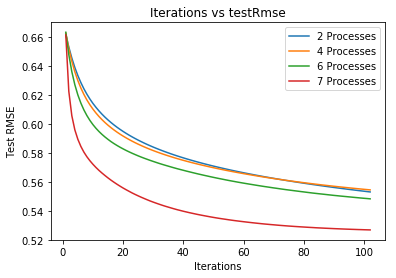

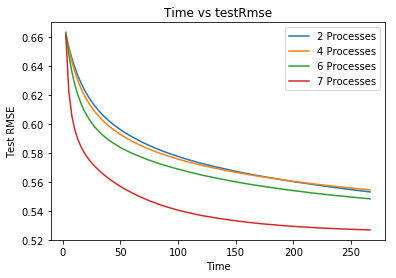

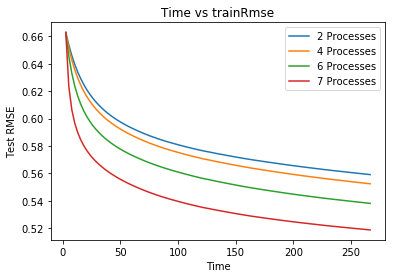

In [126]:
#Plotting efficiency graphs
import pandas as pd
import matplotlib.pyplot as plt
df7 = pd.read_csv('ResidualsVirus2.csv',sep = '\t')
df6 = pd.read_csv('ResidualsVirus4.csv',sep = '\t')
df4 = pd.read_csv('ResidualsVirus6.csv',sep = '\t')
df2 = pd.read_csv('ResidualsVirus7.csv',sep = '\t')
#Iterations
cnt = [i for i in range(1,103)]
#Iterations vs trainRmse
plt.plot(cnt,df2['trainRmse'],label = "2 Processes")
plt.plot(cnt,df4['trainRmse'],label = "4 Processes")
plt.plot(cnt,df6['trainRmse'],label = "6 Processes")
plt.plot(cnt,df7['trainRmse'],label = "7 Processes")
plt.xlabel("Iterations")
plt.ylabel("Train RMSE")
plt.title("Iterations vs trainRmse")
plt.legend()
plt.show()

#Iterations vs testRmse
plt.plot(cnt,df2['testRmse'],label = "2 Processes")
plt.plot(cnt,df4['testRmse'],label = "4 Processes")
plt.plot(cnt,df6['testRmse'],label = "6 Processes")
plt.plot(cnt,df7['testRmse'],label = "7 Processes")
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Iterations vs testRmse")
plt.legend()
plt.show()

#Time vs testRmse
time = df['time'].cumsum()
plt.plot(time,df2['testRmse'],label = "2 Processes")
plt.plot(time,df4['testRmse'],label = "4 Processes")
plt.plot(time,df6['testRmse'],label = "6 Processes")
plt.plot(time,df7['testRmse'],label = "7 Processes")
plt.xlabel("Time")
plt.ylabel("Test RMSE")
plt.title("Time vs testRmse")
plt.legend()
plt.show()

#Time vs trainRmse
plt.plot(time,df2['trainRmse'],label = "2 Processes")
plt.plot(time,df4['trainRmse'],label = "4 Processes")
plt.plot(time,df6['trainRmse'],label = "6 Processes")
plt.plot(time,df7['trainRmse'],label = "7 Processes")
plt.xlabel("Time")
plt.ylabel("Test RMSE")
plt.title("Time vs trainRmse")
plt.legend()
plt.show()

2 Processes


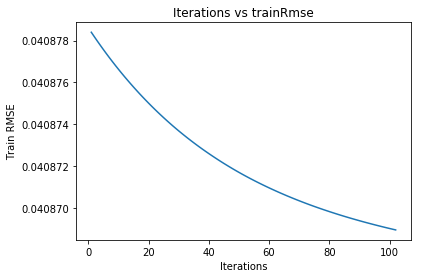

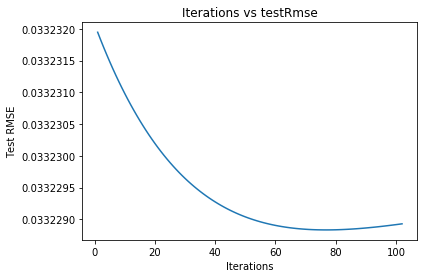

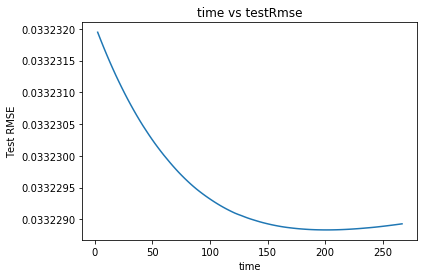

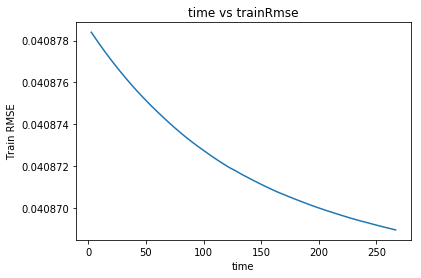

In [144]:
#Plotting efficiency graphs
import pandas as pd
import matplotlib.pyplot as plt
df2 = pd.read_csv('ResidualsKdd2Actual.csv',sep = '\t')
df4 = pd.read_csv('ResidualsKdd2.csv',sep = '\t')
df6 = pd.read_csv('ResidualsKdd6.csv',sep = '\t')
df7 = pd.read_csv('ResidualsKdd7.csv',sep = '\t')
#Iterations
cnt = [i for i in range(1,103)]

print("2 Processes")
#Iterations vs trainRmse
plt.plot(cnt,df2['trainRmse'])
plt.xlabel("Iterations")
plt.ylabel("Train RMSE")
plt.title("Iterations vs trainRmse")
plt.show()

plt.plot(cnt,df2['testRmse'])
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Iterations vs testRmse")
plt.show()

time = df['time'].cumsum()
plt.plot(time,df2['testRmse'])
plt.xlabel("time")
plt.ylabel("Test RMSE")
plt.title("time vs testRmse")
plt.show()

plt.plot(time,df2['trainRmse'])
plt.xlabel("time")
plt.ylabel("Train RMSE")
plt.title("time vs trainRmse")
plt.show()

4 Processes


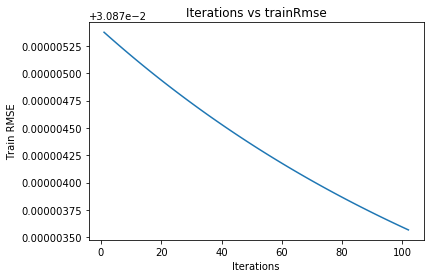

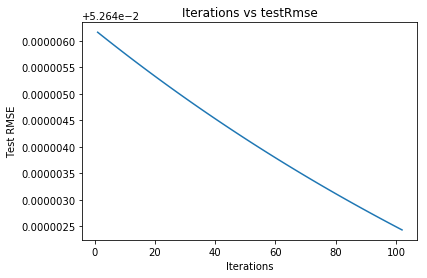

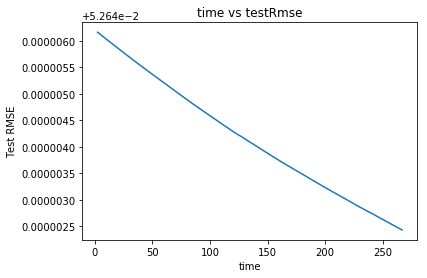

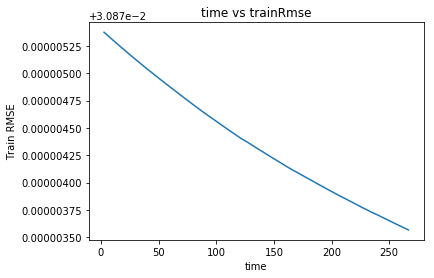

In [145]:
print("4 Processes")
#Iterations vs trainRmse
plt.plot(cnt,df4['trainRmse'])
plt.xlabel("Iterations")
plt.ylabel("Train RMSE")
plt.title("Iterations vs trainRmse")
plt.show()

plt.plot(cnt,df4['testRmse'])
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Iterations vs testRmse")
plt.show()

time = df['time'].cumsum()
plt.plot(time,df4['testRmse'])
plt.xlabel("time")
plt.ylabel("Test RMSE")
plt.title("time vs testRmse")
plt.show()

plt.plot(time,df4['trainRmse'])
plt.xlabel("time")
plt.ylabel("Train RMSE")
plt.title("time vs trainRmse")
plt.show()

6 Processes


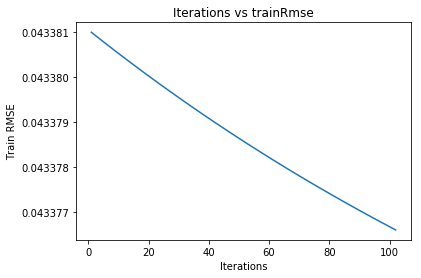

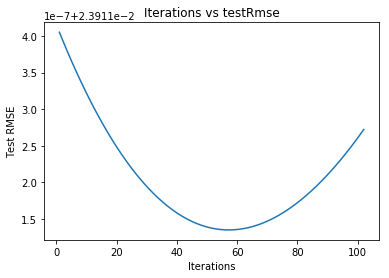

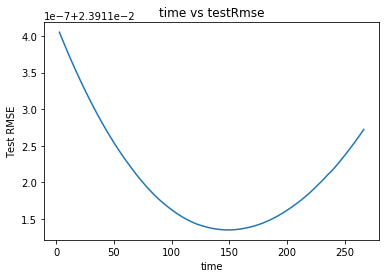

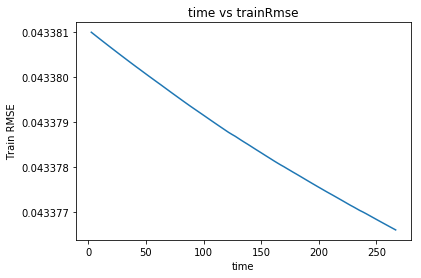

In [146]:
print("6 Processes")
#Iterations vs trainRmse
plt.plot(cnt,df6['trainRmse'])
plt.xlabel("Iterations")
plt.ylabel("Train RMSE")
plt.title("Iterations vs trainRmse")
plt.show()

plt.plot(cnt,df6['testRmse'])
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Iterations vs testRmse")
plt.show()

time = df['time'].cumsum()
plt.plot(time,df6['testRmse'])
plt.xlabel("time")
plt.ylabel("Test RMSE")
plt.title("time vs testRmse")
plt.show()

plt.plot(time,df6['trainRmse'])
plt.xlabel("time")
plt.ylabel("Train RMSE")
plt.title("time vs trainRmse")
plt.show()

7 Processes


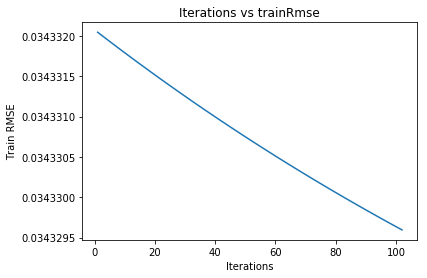

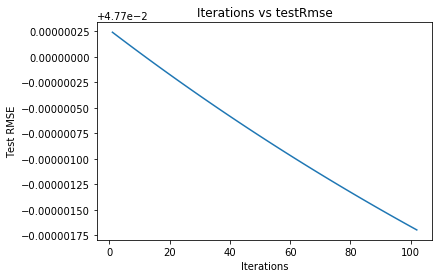

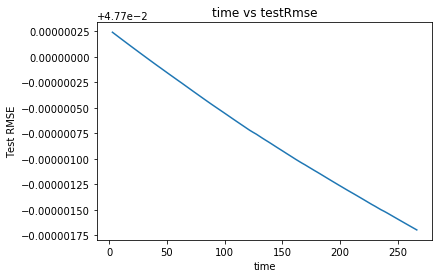

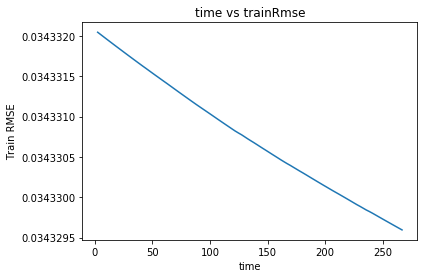

In [147]:
print("7 Processes")
#Iterations vs trainRmse
plt.plot(cnt,df7['trainRmse'])
plt.xlabel("Iterations")
plt.ylabel("Train RMSE")
plt.title("Iterations vs trainRmse")
plt.show()

plt.plot(cnt,df7['testRmse'])
plt.xlabel("Iterations")
plt.ylabel("Test RMSE")
plt.title("Iterations vs testRmse")
plt.show()

time = df['time'].cumsum()
plt.plot(time,df7['testRmse'])
plt.xlabel("time")
plt.ylabel("Test RMSE")
plt.title("time vs testRmse")
plt.show()

plt.plot(time,df7['trainRmse'])
plt.xlabel("time")
plt.ylabel("Train RMSE")
plt.title("time vs trainRmse")
plt.show()

In [180]:
%%file Sklearn.py
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix, vstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split
from mpi4py import MPI

import pandas as pd
import numpy as np
import time
import scipy
import os
import re

#Initialize communicators
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()



def virus():
    path = "/home/kritz/Downloads/dataset/"
    label = []
    data = np.array([])
    #Listing all the files in directory
    for rootdir, subdirs, files in os.walk(path):
        if files:
            for file in sorted(files):
                #Reading the data into sparse matrix from libsvm
                x,y = load_svmlight_file(rootdir+'/'+file)
                #Adding empty rows to compensate for missing columns in these four files
                if file in ["2011-09.txt","2013-07.txt","2013-09.txt","2014-01.txt"]:
                    update = np.zeros((x.shape[0],1))
                    x = scipy.sparse.hstack((x,np.array((update))))
                label.extend(y)
                #Adding all files to same csr matrix
                data = scipy.sparse.vstack((data,x))
    print(len(y),data.shape)
    data = data.tocsr()
    return(data[1:,].tocsr(),label)

#Pre-processing Kdd data
def Kdd():
    path = "/home/kritz/Downloads/cup98LRN.txt"
    df = pd.read_csv(path,low_memory=False)

    #Getting the numerical and categorical columns
    cols = df.columns
    numCol = df._get_numeric_data().columns
    catCol = list(set(cols) - set(numCol))
    #Type casting for float and string
    for each in numCol:
        df[each] = df[each].astype('float')
    for each in catCol:
         df[each] = df[each].astype('category')
            
    #Filling mean values to Nans 
    newDf = pd.get_dummies(df,drop_first = True)  
    newDf = newDf.fillna(newDf.mean())

    #Reducing the dimension of predictor space based on variable importance
    X, y = newDf.loc[:,newDf.columns != 'TARGET_D'], newDf.loc[:,df.columns == 'TARGET_D']
    XNew = SelectKBest(chi2, k=200).fit_transform(X, y)

    return(scipy.sparse.csr_matrix(XNew),y)

if rank == 0:
    tic = time.time()
    data,y = Kdd() 
    x = data[:,:6000]
    y = np.array(y[:6000]).ravel()

    xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=15)

    clf = linear_model.SGDRegressor()
    clf.fit(xTrain,yTrain)
    print(time.time()-tic)

Overwriting Sklearn.py
